## Use scale to pre-processing 11dim with time signals(only use half samples to generate)

## 1.Pre-processing

In [1]:
import os
import time
import torch
import argparse
import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from collections import defaultdict
import torch.multiprocessing as mp
import torch.utils.data
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import numpy

from sklearn import preprocessing

from models_11dim import VAE


device = torch.device('cuda:0')

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
# train_data = datasets.MNIST(root='data', train=True,
#                                    download=True, transform=transform)
# test_data = datasets.MNIST(root='data', train=False,
#                                   download=True, transform=transform)

# data_loader = DataLoader(
#     dataset=dataset, batch_size=args.batch_size, shuffle=True)
# print(len(train_data))

# dataset = MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=True)


sides_3 = np.load('../data/force_torque_sensor/Dataset/3_sides/Data/data.npy')
sides_4 = np.load('../data/force_torque_sensor/Dataset/4_sides/Data/data.npy')
sides_5 = np.load('../data/force_torque_sensor/Dataset/5_sides/Data/data.npy')
sides_6 = np.load('../data/force_torque_sensor/Dataset/6_sides/Data/data.npy')
sides_200 = np.load('../data/force_torque_sensor/Dataset/200_sides/Data/data.npy')



In [2]:
def feature_normalize(data):
    mu = np.mean(data,axis=0)
    std = np.std(data,axis=0)
    return (data - mu)/std

def un_normalize(normalized_data, input_data):
    mu = np.mean(input_data,axis=0)
    std = np.std(input_data,axis=0)
    return normalized_data*std+mu

In [3]:
def extract_trials(x, n):
#     x = feature_normalize(x)
    x = preprocessing.minmax_scale(x, feature_range=(0,1))
    trials=[]
    trial=[]
    compare=0
    for sig in x:
        trial.append(sig[0:n])
        if sig[11] <= compare:
            d = 1002 - len(trial)
            if d >0:
                for i in range(d):
                    trial.append(np.zeros(len(sig[0:n])))
            trials.append(trial)
            trial=[]
        compare=sig[11]
    trials = np.array(trials)
    return trials       


In [4]:
dim=11 # without select the time and counter signal

sides_3_trials = extract_trials(sides_3, dim)
# sides_4_trials = extract_trials(sides_4, num)
# sides_5_trials = extract_trials(sides_5, num)
# sides_6_trials = extract_trials(sides_6, num)
# sides_200_trials = extract_trials(sides_200, num)

print(sides_3_trials[1580][999])

print(np.shape(sides_3_trials))
print(len(sides_3_trials[1000]))
print(sides_3_trials[1000])

[0.99409463 0.81367002 0.48168194 0.99903415 0.62487198 0.29022964
 0.95047635 0.82071828 0.62483573 0.633718   0.99873658]
(1583, 1002, 11)
1002
[[0.99761829 0.35669136 0.6230216  ... 0.65169391 0.60907035 0.63171194]
 [0.99761829 0.35669136 0.6230216  ... 0.64997979 0.57950256 0.63171194]
 [0.99761829 0.35669136 0.6230216  ... 0.61341184 0.57412659 0.63171194]
 ...
 [0.99761829 0.35669136 0.6230216  ... 0.6076981  0.59563043 0.63171194]
 [0.99598465 0.44840978 0.51779794 ... 0.67270165 0.65831302 0.63234365]
 [0.         0.         0.         ... 0.         0.         0.        ]]


### Select the samples

In [5]:
sides_3_trials = sides_3_trials[0:1580]

print(len(sides_3_trials))

limit_trials=[]
count = 0

for trail in sides_3_trials:
    if count % 2 ==1:
        limit_trials.append(trail)
    count+=1

print(len(limit_trials))
    

1580
790


In [6]:
dataset = limit_trials

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 10

data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
train_loader = data_loader
valid_loader = data_loader
test_loader = data_loader

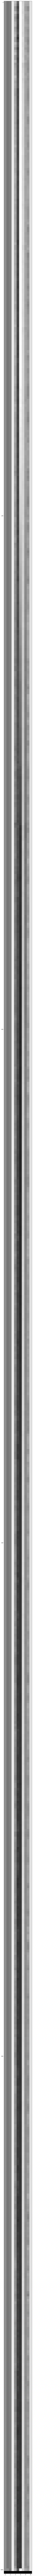

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loader)
images = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,500)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Loss function

In [8]:
def loss_fn(recon_x, x, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x.view(-1, 1002*11), x.view(-1, 1002*11), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # elbo = recon_loss + self.beta * D_kl
    elbo = (BCE + KLD)/ x.size(0)
    return elbo

In [9]:
seed = 0
epochs = 50
latent_size = 2
num_processes = 2
learning_rate = 0.001
print_every = 100


vae = VAE(latent_size=latent_size).float().to(device)

# vae = VAE(
#     encoder_layer_sizes=encoder_layer_sizes,
#     latent_size=latent_size,
#     decoder_layer_sizes=decoder_layer_sizes).to(device)

use_cuda = torch.cuda.is_available
if use_cuda:
    vae.to(device)

logs = defaultdict(list)
    
epochs = epochs
for epoch in range(epochs):
    lr_havel = learning_rate
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr_havel)
    
    for iteration, data in enumerate(train_loader):
        signals = data
        signals = signals.view(signals.size(0), -1)
        if use_cuda:
            signals = signals.to(device).float()
        else:
            signals = signals.float()

        optimizer.zero_grad()
        recon_x, mean, log_var, z = vae(signals)
        elbo = loss_fn(recon_x, signals, mean, log_var)
        loss = elbo
        loss.backward()
        optimizer.step()

        logs['loss'].append(loss.item())

        if iteration % print_every == 0 or iteration == len(train_loader)-1:
            valid_correct = 0
            valid_total = 0
            test_correct = 0
            test_total = 0

            for valid_data in valid_loader:
                valid = valid_data
                valid = signals.view(valid.size(0), -1)
                if use_cuda:
                    input_valid = valid.to(device).float()
                else:
                    input_valid = valid.float()
                valid_recon_x, valid_mean, valid_log_var, valid_z = vae(input_valid)
                valid_elbo = loss_fn(valid_recon_x, input_valid, valid_mean, valid_log_var)
                criterion = nn.MSELoss()
                valid_loss = criterion(valid_recon_x, input_valid)
                logs['valid_elbo'].append(valid_elbo.item())
                logs['valid_loss'].append(valid_loss.item())
                valid_total +=1
                if valid_loss < 0.05:
                    valid_correct += 1
            valid_acc = valid_correct / valid_total  
            print("Epoch {:02d}/{:02d} Batch {:04d}/{:d} |Train_ELBO {:5f} |Valid_ELBO{:5f} |Valid_loss{:5f} |Valid_accuary{:5f} |Leaarning_rate{:5f}".format(
                epoch, epochs, iteration, len(train_loader)-1, loss.item(), valid_elbo.item(), valid_loss.item(), valid_acc, lr_havel))

    lr_havel = lr_havel*0.9
    torch.save(vae, 'vae_all_signals_1002_scale_unscale_11dim_half_sample.pkl')  

Epoch 00/50 Batch 0000/78 |Train_ELBO 7928.768066 |Valid_ELBO7938.760254 |Valid_loss0.066320 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 00/50 Batch 0078/78 |Train_ELBO 7114.134277 |Valid_ELBO7390.874512 |Valid_loss0.038059 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 01/50 Batch 0000/78 |Train_ELBO 7228.557129 |Valid_ELBO7418.987793 |Valid_loss0.040068 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 01/50 Batch 0078/78 |Train_ELBO 6709.886719 |Valid_ELBO6697.133789 |Valid_loss0.028919 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 02/50 Batch 0000/78 |Train_ELBO 6974.021973 |Valid_ELBO6860.103027 |Valid_loss0.027767 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 02/50 Batch 0078/78 |Train_ELBO 7371.960938 |Valid_ELBO7207.963379 |Valid_loss0.038015 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 03/50 Batch 0000/78 |Train_ELBO 6889.028809 |Valid_ELBO7302.857910 |Valid_loss0.035860 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 03/50 Batch 00

Epoch 29/50 Batch 0078/78 |Train_ELBO 6700.850098 |Valid_ELBO6625.269043 |Valid_loss0.021304 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 30/50 Batch 0000/78 |Train_ELBO 6375.943359 |Valid_ELBO6407.364746 |Valid_loss0.016383 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 30/50 Batch 0078/78 |Train_ELBO 6703.828125 |Valid_ELBO6721.024902 |Valid_loss0.014191 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 31/50 Batch 0000/78 |Train_ELBO 6716.920410 |Valid_ELBO6521.935059 |Valid_loss0.023157 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 31/50 Batch 0078/78 |Train_ELBO 6895.214844 |Valid_ELBO6893.174316 |Valid_loss0.025585 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 32/50 Batch 0000/78 |Train_ELBO 6874.211914 |Valid_ELBO6907.306152 |Valid_loss0.018675 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 32/50 Batch 0078/78 |Train_ELBO 6594.774902 |Valid_ELBO6621.229980 |Valid_loss0.020034 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 33/50 Batch 00

# 2. Use the oringinal signal to Generate>>>>>>

In [12]:
vae = torch.load('vae_all_signals_1002_scale_unscale_11dim_half_sample.pkl').to(device)


In [13]:
import torch.utils.data

batch_size = 10
test_loader = data_loader

vae=vae.to(device)


recon_signals=[]
latent_space=[]

for iteration, test in enumerate(test_loader):
    test = test.view(test.size(0), -1)
    test = test.to(device).float()
    test_recon_x, test_mean, test_log_var, test_z = vae(test)
    test_recon_x = test_recon_x.view(batch_size, 1002, 11)
    test_recon_x=test_recon_x.cpu().detach().numpy()
    latent_space=test_z.cpu().detach().numpy()

    recon_signals.extend(test_recon_x)
#     latent_space.extend(latent_space)
    
#     if iteration ==10:
#         break
    
recon_signals = np.array(recon_signals)
latent_space = np.array(latent_space)

In [14]:
print(type(recon_signals[0]))
print(recon_signals[0])

print(len(recon_signals))
print(len(recon_signals[0]))
# print(recon_signals)

<class 'numpy.ndarray'>
[[0.806066   0.28991812 0.43047422 ... 0.692692   0.62185866 0.4451958 ]
 [0.80841225 0.28362596 0.44480765 ... 0.61167747 0.57493544 0.4479261 ]
 [0.8084134  0.2921921  0.43491432 ... 0.6182355  0.5562244  0.4431962 ]
 ...
 [0.8147527  0.29297036 0.4893443  ... 0.5962143  0.6024359  0.44349796]
 [0.75206363 0.38476786 0.4276419  ... 0.61256367 0.585504   0.41066846]
 [0.03595157 0.01376674 0.02276231 ... 0.028314   0.02530576 0.01228319]]
790
1002


In [15]:
# for i in range(len(recon_signals[0])):
#     recon_signals[:,i]=preprocessing.minmax_scale(
#         recon_signals[:,i], feature_range=(np.min(sides_3_trials[:,i]),np.max(sides_3_trials[:,i])))


# # recon_signals = un_normalize(recon_signals, sides_3_trials)
# generate_signals = recon_signals

# np.min(sides_3_trials[:,i])

## 2.1 Change shape

In [16]:
generate_signals=[]
for trial in recon_signals:
    generate_signals.extend(trial)
generate_signals = np.array(generate_signals)

print(np.shape(generate_signals))
print(len(generate_signals))

(791580, 11)
791580


## 2.1 Un pre-process(here we can select to train use normalize or scale and also generate)

In [17]:
for i in range(len(generate_signals[0])):
    generate_signals[:,i]=preprocessing.minmax_scale(
        generate_signals[:,i], feature_range=(np.min(sides_3[:,i]),np.max(sides_3[:,i])))
    
generated_signals=generate_signals

print(generated_signals[100])

[ 6.3142395e-03 -3.4319726e-03  2.7468632e-06 -1.6681962e-02
 -9.1231346e-02  1.9831924e+00  5.2576828e-01  4.0359020e-02
  4.2343855e-02  1.3251141e-02  7.4559692e+02]


791580


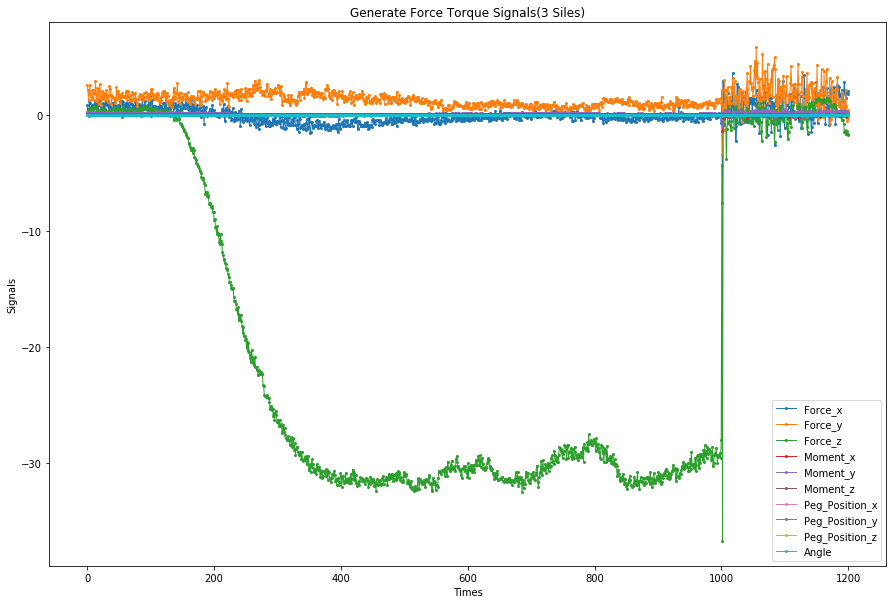

In [18]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

cmap=plt.cm.get_cmap(plt.cm.viridis,143)


# plt.rcParams['font.size'] = 11.
# plt.rcParams['font.family'] = 'Comic Sans MS'
# plt.rcParams['axes.labelsize'] = 15.
# plt.rcParams['xtick.labelsize'] = 10.
# plt.rcParams['ytick.labelsize'] = 10.

plt.figure(figsize=(15,10))



sides = generated_signals
print(len(sides))

first = 0
slip = 1200

# Peg_Position_x = sides[:,0]
Peg_Position_x = sides[:,0][first:slip]
# Peg_Position_x = sides[:,0][0:10:slip]

# Peg_Position_y = sides[:,1]
Peg_Position_y = sides[:,1][first:slip]
# Peg_Position_y = sides[:,1][0:10:slip]

# Peg_Position_z = sides[:,2]
Peg_Position_z = sides[:,2][first:slip]
# Peg_Position_z = sides[:,2][0:10:slip]

# Angle = sides[:,3]
Angle = sides[:,3][first:slip]
# Angle = sides[:,3][0:10:slip]

# Force_x = sides[:,4]
Force_x = sides[:,4][first:slip]
# Force_x = sides[:,4][0:10:slip]

# Force_y = sides[:,5]
Force_y = sides[:,5][first:slip]
# Force_y = sides[:,5][0:10:slip]

# Force_z = sides[:,6]
Force_z = sides[:,6][first:slip]
# Force_z = sides[:,6][0:10:slip]

# Moment_x = sides[:,7]
Moment_x = sides[:,7][first:slip]
# Moment_x = sides[:,7][0:10:slip]

# Moment_y = sides[:,8]
Moment_y = sides[:,8][first:slip]
# Moment_y = sides[:,8][0:10:slip]

# Moment_z = sides[:,9]
Moment_z = sides[:,9][first:slip]
# Moment_z = sides[:,9][0:10:slip]


# # Time = sides[:,10]
# Time = sides[:,10][first:slip]
# # Time = sides[:,10][0:10:slip]

# # Counter = sides[:,11]
# Counter = sides[:,11][first:slip]
# # Counter = sides[:,11][0:10:slip]

# # print(Counter[1001])
# print(min(Counter))
# print(max(Counter))


# x = Time
x = np.linspace(0,len(Moment_z),len(Moment_z))

plt.plot(x, Force_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_x')
plt.plot(x, Force_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_y')
plt.plot(x, Force_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_z')

plt.plot(x, Moment_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_x')
plt.plot(x, Moment_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_y')
plt.plot(x, Moment_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_z')

plt.plot(x, Peg_Position_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_x')
plt.plot(x, Peg_Position_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_y')
plt.plot(x, Peg_Position_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_z')

plt.plot(x, Angle, marker='o', linestyle='-', markersize=2, linewidth=1, label='Angle')
# plt.plot(x, Counter, marker='o', linestyle='-', markersize=2, linewidth=1, label='Counter')


plt.xlabel('Times')
plt.ylabel('Signals')
plt.title('Generate Force Torque Signals(3 Siles)')
plt.legend(loc='lower right')
# plt.savefig("peg_position_and_angle_mini_generate.png")
plt.show()


# 3. Use the random latent space to Generate>>>>>>


[[ 2.2781758   5.389389  ]
 [ 1.3864543  -2.6908922 ]
 [ 1.915371    1.297396  ]
 [ 1.5064381   0.95979726]
 [-1.134978    2.251744  ]
 [-3.3203897  -1.5228735 ]
 [-0.3100806   0.9678489 ]
 [-4.066669    0.11057717]
 [ 2.8494024  -4.694054  ]
 [ 1.0294836  -0.17602673]]


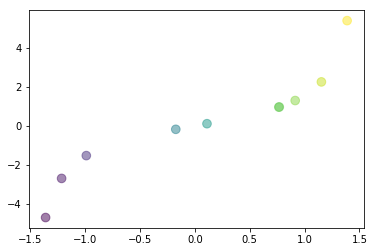

In [19]:
print(latent_space)

import matplotlib.pyplot as plt
import numpy as np
X = latent_space[:,0]
Y = latent_space[:,1]

colors = np.arctan(Y,X) # color

plt.scatter(X, Y, s=75, c=colors, alpha=.5)

tensor([[-0.0790,  0.9266],
        [-1.3997,  0.6830],
        [ 0.5215, -0.5850],
        [ 0.1291,  0.7839],
        [-0.5814,  0.9015],
        [ 0.3974, -0.0237],
        [ 0.4423, -0.9384],
        [-0.6130, -0.1314],
        [ 0.8935,  0.7113],
        [ 1.2419, -0.7911]], device='cuda:0')


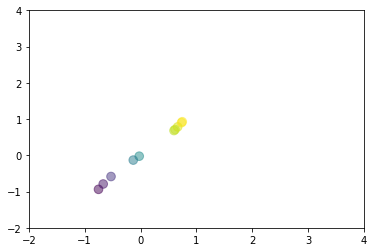

In [20]:
# batch_size = 10
z = torch.randn([batch_size, 2]).to(device)
# z = torch.FloatTensor(latent_space).to(device)


visual_z = z.cpu().numpy()
import matplotlib.pyplot as plt
import numpy as np
X = visual_z[:,0]
Y = visual_z[:,1]

colors = np.arctan(Y,X) # color

plt.scatter(X, Y, s=75, c=colors, alpha=.5)
plt.xlim(-2,4)
plt.ylim(-2,4)

print(z)

In [21]:
recon_x = vae.decoder(z)

print(type(recon_x[0]))
print(recon_x[0])

print(len(recon_x))
print(len(recon_x[0]))

print(recon_x[0])

<class 'torch.Tensor'>
tensor([0.7321, 0.1565, 0.4887,  ..., 0.0140, 0.0141, 0.0143], device='cuda:0',
       grad_fn=<SelectBackward>)
10
11022
tensor([0.7321, 0.1565, 0.4887,  ..., 0.0140, 0.0141, 0.0143], device='cuda:0',
       grad_fn=<SelectBackward>)


In [22]:
recon_x = recon_x.view(batch_size,1002,11)
# generate_signals = recon_x.cpu().detach().numpy()

z_generate_signals=[]
for trial in recon_x:
    trial = trial.cpu().detach().numpy()
    z_generate_signals.extend(trial)
z_generate_signals = np.array(z_generate_signals)


# print(np.shape(generate_signals))
print(len(z_generate_signals))
# print(generate_signals[0])
# print(type(generate_signals))


10020


In [23]:
for i in range(len(z_generate_signals[0])):
    z_generate_signals[:,i]=preprocessing.minmax_scale(
        z_generate_signals[:,i], feature_range=(np.min(sides_3[:,i]),np.max(sides_3[:,i])))
    
z_generated_signals=z_generate_signals

print(len(z_generated_signals))
print(np.shape(z_generated_signals))

10020
(10020, 11)


10020


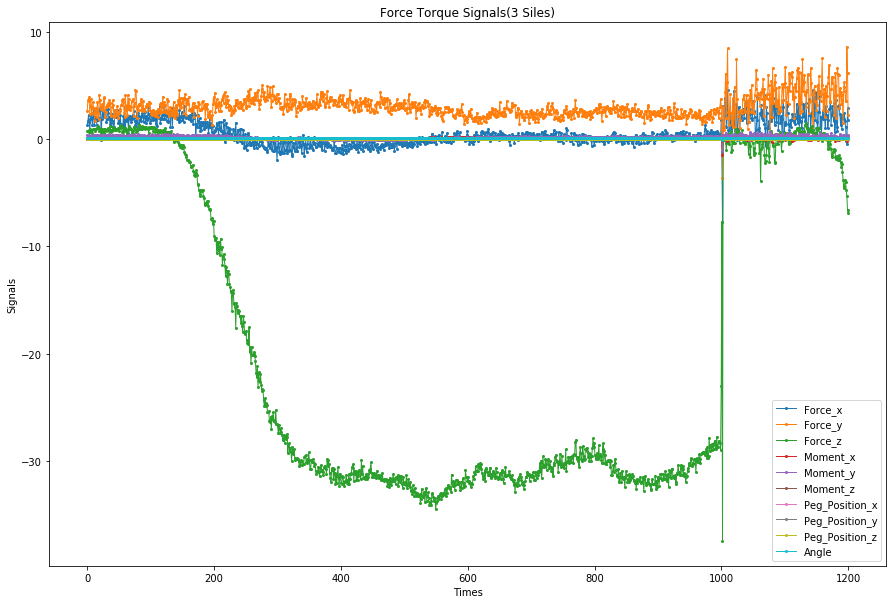

In [24]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

cmap=plt.cm.get_cmap(plt.cm.viridis,143)


# plt.rcParams['font.size'] = 11.
# plt.rcParams['font.family'] = 'Comic Sans MS'
# plt.rcParams['axes.labelsize'] = 15.
# plt.rcParams['xtick.labelsize'] = 10.
# plt.rcParams['ytick.labelsize'] = 10.

plt.figure(figsize=(15,10))



sides = z_generate_signals
print(len(sides))

slip = 1200

# Peg_Position_x = sides[:,0]
Peg_Position_x = sides[:,0][:slip]
# Peg_Position_x = sides[:,0][0:10:slip]

# Peg_Position_y = sides[:,1]
Peg_Position_y = sides[:,1][:slip]
# Peg_Position_y = sides[:,1][0:10:slip]

# Peg_Position_z = sides[:,2]
Peg_Position_z = sides[:,2][:slip]
# Peg_Position_z = sides[:,2][0:10:slip]

# Angle = sides[:,3]
Angle = sides[:,3][:slip]
# Angle = sides[:,3][0:10:slip]

# Force_x = sides[:,4]
Force_x = sides[:,4][:slip]
# Force_x = sides[:,4][0:10:slip]

# Force_y = sides[:,5]
Force_y = sides[:,5][:slip]
# Force_y = sides[:,5][0:10:slip]

# Force_z = sides[:,6]
Force_z = sides[:,6][:slip]
# Force_z = sides[:,6][0:10:slip]

# Moment_x = sides[:,7]
Moment_x = sides[:,7][:slip]
# Moment_x = sides[:,7][0:10:slip]

# Moment_y = sides[:,8]
Moment_y = sides[:,8][:slip]
# Moment_y = sides[:,8][0:10:slip]

# Moment_z = sides[:,9]
Moment_z = sides[:,9][:slip]
# Moment_z = sides[:,9][0:10:slip]

x = np.linspace(0,len(Moment_z),len(Moment_z))

plt.plot(x, Force_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_x')
plt.plot(x, Force_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_y')
plt.plot(x, Force_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_z')

plt.plot(x, Moment_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_x')
plt.plot(x, Moment_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_y')
plt.plot(x, Moment_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_z')

plt.plot(x, Peg_Position_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_x')
plt.plot(x, Peg_Position_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_y')
plt.plot(x, Peg_Position_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_z')

plt.plot(x, Angle, marker='o', linestyle='-', markersize=2, linewidth=1, label='Angle')
# plt.plot(x, Counter, marker='o', linestyle='-', markersize=2, linewidth=1, label='Counter')


plt.xlabel('Times')
plt.ylabel('Signals')
plt.title('Force Torque Signals(3 Siles)')
plt.legend(loc='lower right')
plt.show()